# Spur Fitting

In [1]:
import pathlib
import warnings
import warnings
warnings.filterwarnings('ignore')
import os

import sys
sys.path.append('../code/')
import pm_model_func as pmf

# Third-party
import astropy.coordinates as coord
import astropy.table as at
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.lib.recfunctions import stack_arrays
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData
from scipy.stats import binned_statistic

import arviz as az
import pymc3 as pm
import seaborn as sns
from tqdm import trange
from pymc3 import *
import theano.tensor as tt
import pymc3_ext as pmx
from patsy import dmatrix

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


In [237]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': False})
    
plot_pretty(fontsize=20, labelsize=20)

In [2]:
import importlib
importlib.reload(pmf)

gaia = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
gaia = gaia[(gaia.phi1 > -45) & (gaia.phi1 < -25)]

stream_mask = gaia.gi_cmd_mask
g = gaia[(stream_mask)]# & (gaia.g_0 < 18)

dist = g.get_distance(min_parallax=1e-3*u.mas)
c = g.get_skycoord(distance=dist)
stream_coord = c.transform_to(gc.GD1)
phi1 = stream_coord.phi1.degree
phi2 = stream_coord.phi2.degree
pm1 = stream_coord.pm_phi1_cosphi2
pm2 = stream_coord.pm_phi2

after = GaiaData('../data/sorted_pm_member_prob_all_stars_8comp.fits')
after = after[(after.phi1 > -45) & (after.phi1 < -25)]

g_sorted, obs_pm_all, obs_pm_cov_all, phi1_stream_all, phi2_stream_all, bkg_ind = pmf.pre_model(gaia, g, after)
ln_bg_prob_all = after.pm_ln_bkg_prob.astype('float64')
ln_bg_prob = ln_bg_prob_all[bkg_ind]

In [25]:
obs_pm_all.shape

(133348, 2)

In [165]:
import importlib
importlib.reload(pmf)

with pm.Model() as model:
    
    # mixture weight
    alpha = pm.Uniform('alpha', lower = 0, upper = 1)
    beta = pm.Uniform('beta', lower=0, upper = 1, testval=0.3)

    loglike_fg_pm, loglike_fg_pm_all = pmf.short_pm_model_spur(model, obs_pm_all, obs_pm_cov_all, 
                                                           phi1_stream_all, bkg_ind)
    ll_fg_pm = pm.Deterministic('ll_fg_pm', tt.log(alpha) + loglike_fg_pm)
    
    loglike_fg_phi2, loglike_fg_phi2_all = pmf.short_phi2_model_spur(model, phi1_stream_all, 
                                                                            phi2_stream_all, bkg_ind,)
    loglike_fg_phi2 = loglike_fg_phi2.reshape(loglike_fg_pm.shape)
    ll_fg_phi2 = pm.Deterministic('ll_fg_phi2', tt.log(beta) + loglike_fg_phi2)
    
    loglike_fg_spur =pmf.short_spur_model(model, phi1_stream_all, phi2_stream_all, 
                                                              obs_pm_all, obs_pm_cov_all, bkg_ind)   
    loglike_fg_spur = loglike_fg_spur.reshape(loglike_fg_pm.shape)
    ll_fg_phi2_spur = pm.Deterministic('ll_fg_phi2_spur', tt.log(alpha) + tt.log(1-beta) + loglike_fg_spur)
    
    #total track likelihood (including spur)
    loglike_fg_phi2_total = pm.Deterministic('ll_fg_phi2_total', pm.logaddexp(loglike_fg_phi2, loglike_fg_spur))
    
    #total foreground likelihood
    loglike_fg = loglike_fg_pm + loglike_fg_phi2_total
    ll_fg_full = pm.Deterministic('ll_fg_full', tt.log(alpha) + loglike_fg)

    ll_bg_full = pm.Deterministic('ll_bg_full', tt.log(1 - alpha) + ln_bg_prob)

    loglike = pm.logaddexp(ll_fg_full, ll_bg_full)
    pm.Potential("loglike", loglike)

In [166]:
with model:
    res, logp = pmx.optimize(start={'b4': 0.5,
                                'ln_std_phi2_spur': np.log(0.1),
                                'beta': 0.3}, 
                             return_info = True)

optimizing logp for variables: [ln_std_pm_spur, mean_pm_spur, std_phi2_spur, spur_track_scale, std_phi2_stream, mean_phi2_stream, ln_std_pm_stream, mean_pm_stream, beta, alpha]


message: Optimization terminated successfully.
logp: -197874.14269018013 -> -174748.4084905748


In [197]:
post_member_prob3 = np.exp(
            res['ll_fg_full'] 
            - np.logaddexp(res['ll_fg_full'], res['ll_bg_full']))

post_member_prob3_pm = np.exp(
            res['ll_fg_pm'] 
            - np.logaddexp(res['ll_fg_pm'], res['ll_bg_full']))

post_member_prob3_phi2 = np.exp(
            res['ll_fg_phi2_total'] 
            - np.logaddexp(res['ll_fg_phi2_total'], res['ll_bg_full']))

post_member_prob3_spur = np.exp(
            res['ll_fg_phi2_spur'] 
            - np.logaddexp(res['ll_fg_phi2_spur'], res['ll_bg_full']))

print('# among sel stars with total member prob > 0.1: {}'.format((post_member_prob3 > 0.1).sum()))
print('# among sel stars with PM member prob > 0.1: {}'.format((post_member_prob3_pm > 0.1).sum()))
print('# among sel stars with track member prob > 0.1: {}'.format((post_member_prob3_phi2 > 0.1).sum()))

# among sel stars with total member prob > 0.1: 212
# among sel stars with PM member prob > 0.1: 291
# among sel stars with track member prob > 0.1: 3322


In [198]:
tbl = at.Table()
tbl['phi1'] = phi1_stream_all[bkg_ind]
tbl['phi2'] = phi2_stream_all[bkg_ind]
tbl['g_0'] = g_sorted.g_0[bkg_ind]
tbl['i_0'] = g_sorted.i_0[bkg_ind]
tbl['pm1'] = obs_pm_all[:,0][bkg_ind]
tbl['pm2'] = obs_pm_all[:,1][bkg_ind]
tbl['pm_cov'] = obs_pm_cov_all[bkg_ind]
tbl['ln_bg_prob'] = ln_bg_prob_all[bkg_ind]
tbl['post_member_prob'] = post_member_prob3
tbl['post_member_prob_pm'] = post_member_prob3_pm
tbl['post_member_prob_phi2'] = post_member_prob3_phi2
tbl['post_member_prob_spur'] = post_member_prob3_spur

tbl.write('../data/member_prob_3_spur.fits', overwrite=True)

Text(0.5, 1.0, 'Membership Probabilities Combined')

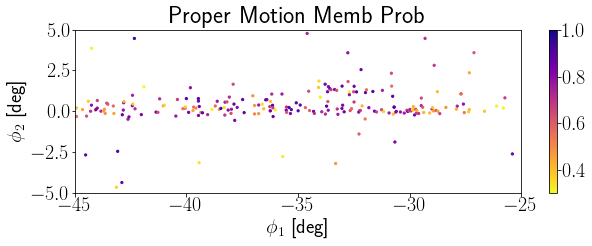

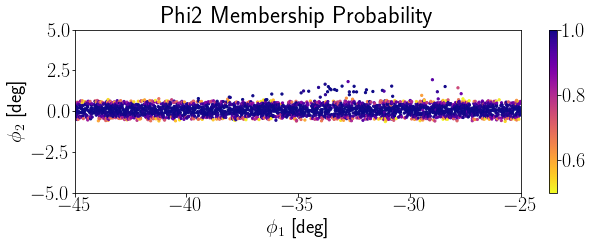

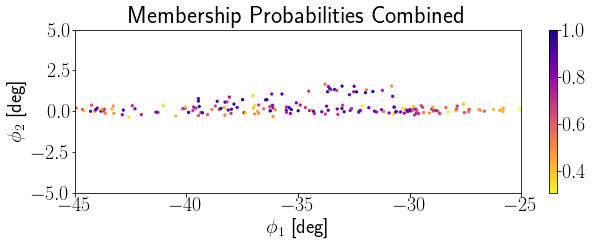

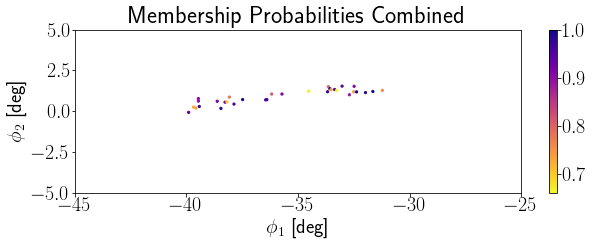

In [249]:
after3 = GaiaData('../data/member_prob_3_spur.fits')

high_memb_prob3_pm = after3[after3.post_member_prob_pm > 0.3]
high_memb_prob3_phi2 = after3[after3.post_member_prob_phi2 > 0.5]
high_memb_prob3_spur = after3[(after3.post_member_prob_spur > 0.5)]
high_memb_prob3 = after3[(after3.post_member_prob > 0.3)]

plt.figure(figsize=(10,3))
plt.scatter(high_memb_prob3_pm.phi1, high_memb_prob3_pm.phi2, c = high_memb_prob3_pm.post_member_prob_pm,
            s = 5, cmap='plasma_r', vmax = 1)
plt.colorbar()
plt.xlim(-45, -25); plt.ylim(-5, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Proper Motion Memb Prob')

plt.figure(figsize=(10,3))
plt.scatter(high_memb_prob3_phi2.phi1, high_memb_prob3_phi2.phi2, c=high_memb_prob3_phi2.post_member_prob_phi2, 
            s = 5, cmap='plasma_r', vmin=0.5, vmax=1)
plt.colorbar()
plt.xlim(-45, -25); plt.ylim(-5, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Phi2 Membership Probability')

plt.figure(figsize=(10,3))
plt.scatter(high_memb_prob3.phi1, high_memb_prob3.phi2, c = high_memb_prob3.post_member_prob, 
            s = 5, cmap='plasma_r', vmax=1)
plt.colorbar()
plt.xlim(-45, -25); plt.ylim(-5, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Membership Probabilities Combined')

plt.figure(figsize=(10,3))
plt.scatter(high_memb_prob3_spur.phi1, high_memb_prob3_spur.phi2, c = high_memb_prob3_spur.post_member_prob, 
            s = 5, cmap='plasma_r', vmax=1)
plt.colorbar()
plt.xlim(-45, -25); plt.ylim(-5, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Membership Probabilities Combined')
#plt.savefig('../memb_probabilities_stream_with_spur.jpg')

In [250]:
print(res['mean_pm_stream'], res['ln_std_pm_stream'])
print(res['mean_pm_spur'], res['ln_std_pm_spur'])

[-13.0601125   -3.23486399] [-1.50004766 -2.26577186]
[-13.12073219  -3.22434326] [-2.43110091 -3.11567665]


In [251]:
np.max(res['ll_fg_phi2_spur'])

-3.462442576244667

Text(0.5, 1.0, 'Proper Motion Memb Prob')

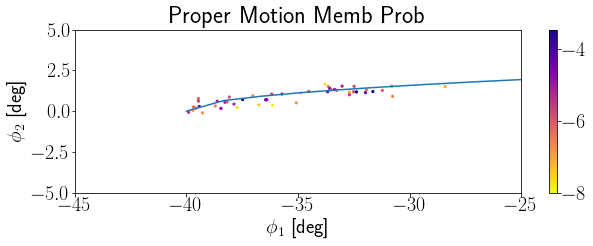

In [252]:
plt.figure(figsize=(10,3))
plt.scatter(after3.phi1[res['ll_fg_phi2_spur']>-8], after3.phi2[res['ll_fg_phi2_spur']>-8],
            c = res['ll_fg_phi2_spur'][res['ll_fg_phi2_spur']>-8],
            s = 5, cmap='plasma_r', vmin=-8)
plt.colorbar()
plt.plot(np.linspace(-40, -25, 10), 0.5*np.sqrt(np.linspace(-40, -25, 10)+40))
plt.xlim(-45, -25); plt.ylim(-5, 5); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Proper Motion Memb Prob')

Text(0, 0.5, '$\\mu_{\\phi_2}$')

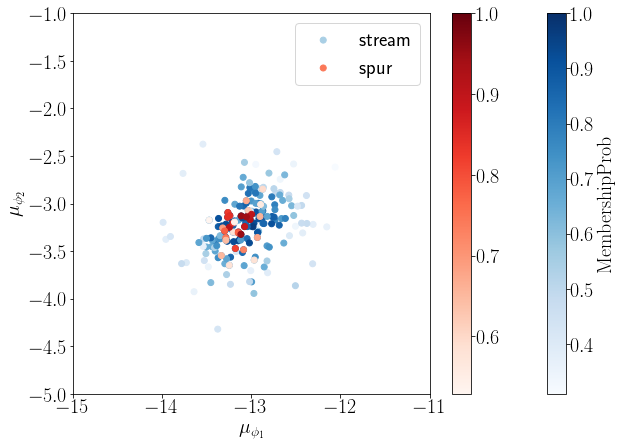

In [254]:
plt.figure(figsize = (10,7))
plt.scatter(high_memb_prob3.pm1, high_memb_prob3.pm2, c = high_memb_prob3.post_member_prob,
            cmap='Blues',vmax=1, label = 'stream')
plt.colorbar(label = r'$\textrm{Membership}  \textrm{Prob}$')

plt.scatter(high_memb_prob3_spur.pm1, high_memb_prob3_spur.pm2, c = high_memb_prob3_spur.post_member_prob_spur, 
            cmap='Reds', vmax=1, label = 'spur')
plt.colorbar()
plt.legend()
plt.xlim(-15, -11)
plt.ylim(-5,-1)
plt.xlabel(r'$\mu_{\phi_1}$')
plt.ylabel(r'$\mu_{\phi_2}$')
